# SMB Figures For State of the Climate Report. 
## Things to do
1. Test code with monthly data made from hourly data
2. Document code
3. Make code run seamlessley if you use grounded ice or all ice
4. Push to github

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as colors
from palettable.colorbrewer.sequential import *
from palettable.cmocean.sequential import *
from palettable.colorbrewer.diverging import *
from calendar import monthrange
from scipy import stats
import geopandas as gpd

# Figure 1: Timeseries of 1980 - 2020 Annual Antarctic SMB

## Load Data

In [2]:
data_path = "/scratch/summit/erke2265/MERRA2_monthly/"

# Grid Area
ga = xr.open_dataset("/projects/erke2265/SOTC_AIS_SMB/MERRA2_gridarea.nc")
ga = ga['cell_area'][0:101,:]

## Data Manipulation

In [3]:
# Calculate seconds in each month
seconds = np.zeros(492); seconds[:] = np.nan
count = -1
for year in range(1980, 2020 + 1):
    for month in range(1, 12 + 1):
        count = count + 1
        tmp = monthrange(year, month)
        seconds[count] = float(tmp[1]) * 24 * 60 * 60
        
# Grounded Ice Sheet Masks
# mask_path = "/projects/erke2265/SOTC_AIS_SMB/AIS_Grounded_basins_Zwally_MERRA2grid.nc"
mask_path = "/projects/erke2265/SOTC_AIS_SMB/AIS_basins_Zwally_MERRA2grid.nc"
mask = xr.open_dataset(mask_path)
mask = mask['Zwallybasins'][0:101,:]
mask = mask / mask

# SMB
smb_yearly = np.zeros(41)
month_count = -1
year_count = -1
for j in range(1980, 2020 + 1):
    year_count = year_count + 1
    # Precipitation
    sn = xr.open_dataset(data_path + "PRECSN_monthly_" + str(j) + ".nc")
    ls = xr.open_dataset(data_path + "PRECLS_monthly_" + str(j) + ".nc")
    cu = xr.open_dataset(data_path + "PRECCU_monthly_" + str(j) + ".nc")

    # Evaporation 
    evap = xr.open_dataset(data_path + "EVAP_monthly_" + str(j) + ".nc")

    smb = sn['PRECSN'] + ls['PRECLS'] + cu['PRECCU'] - evap['EVAP']
#     smb = sn['PRECSN'] + ls['PRECLS'] + cu['PRECCU'] #- evap['EVAP']
#     smb = evap['EVAP']
    for k in range(0, 12):
        month_count = month_count + 1
        smb[k,:,:] = smb[k,:,:] * seconds[month_count]
    smb = smb.sum(dim = "time").values * mask.values
    smb = smb * ga; 
    smb = smb.sum(dim='lat').sum(dim='lon') / 1e12 # in Gt
    smb_yearly[year_count] = smb

FileNotFoundError: [Errno 2] No such file or directory: b'/scratch/summit/erke2265/MERRA2_monthly/EVAP_hourly_1980.nc'

In [34]:
mask_path = "/projects/erke2265/SOTC_AIS_SMB/AIS_Grounded_basins_Zwally_MERRA2grid.nc"
# mask_path = "/projects/erke2265/SOTC_AIS_SMB/AIS_basins_Zwally_MERRA2grid.nc"
mask = xr.open_dataset(mask_path)
# mask.plot()
mask_values = mask.values
n_M2_AIS_grounded_grid_cells = mask_values[~np.isnan(mask_values)]
print(len(n_M2_AIS_grounded_grid_cells))

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [35]:
mask

<xarray.Dataset>
Dimensions:       (lat: 361, lon: 576)
Coordinates:
  * lon           (lon) float32 -180.0 -179.375 -178.75 ... 178.75 179.375
  * lat           (lat) float32 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
Data variables:
    Zwallybasins  (lat, lon) float64 ...
Attributes:
    CDI:                 Climate Data Interface version 1.9.2 (http://mpimet....
    Conventions:         CF-1.5
    history:             Wed Jan 22 15:40:36 2020: cdo remapbil,grid_MERRA2.t...
    GDAL_AREA_OR_POINT:  Area
    GDAL:                GDAL 2.0.0, released 2015/06/14
    CDO:                 Climate Data Operators version 1.9.2 (http://mpimet....

## Plot timeseries

<Figure size 432x288 with 0 Axes>

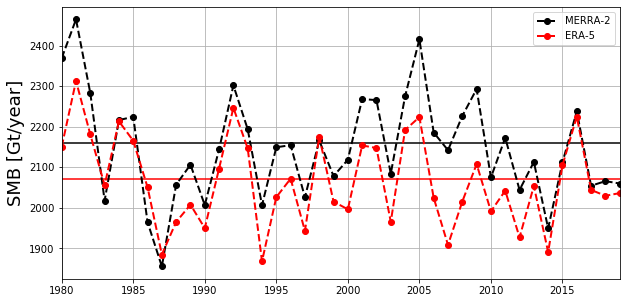

In [21]:
E5_Antartica_SMB_annual_1980_2018_total_Gt = \
    np.array(np.loadtxt('E5_Antartica_grounded_SMB_annual_total_ts_1980_2018.nc', delimiter=',',unpack=True))

## Plot Timeseries
plt.figure(1)
fig1 = plt.figure(figsize = (10, 5))
year = np.arange(1980, 2020+1)
plt.plot(year, smb_yearly, 'ko--', linewidth=2, label='MERRA-2')
plt.plot(np.arange(1980,2019+1), E5_Antartica_SMB_annual_1980_2018_total_Gt, 'ro--', linewidth=2, label='ERA-5')
plt.hlines(2159, 1980, 2019, colors='k', linestyle='solid')
plt.hlines(2070, 1980, 2019, colors='r', linestyle='solid')
plt.xlim([1980, 2019])
plt.grid()
plt.legend()
# plt.title("MERRA-2 Annual AIS SMB", fontsize=18)
plt.ylabel("SMB [Gt/year]", fontsize=18)
plt.savefig('SMB_1980_2020_Timeseries.pdf', format='pdf', dpi=100)

# plt.figure(2)
# fig2 = plt.figure(figsize = (10, 5))
# plt.plot(year, smb_yearly - E5_Antartica_SMB_annual_1980_2018_total_Gt)
# slope, intercept, r_value, p_value, std_err = \
#     stats.linregress(year, smb_yearly - E5_Antartica_SMB_annual_1980_2018_total_Gt)
# print(slope)
# print(p_value)

In [78]:
# Calculate mean/std yearly grounded smb
print(np.nanmean(smb_yearly[1:31]))
print(np.nanstd(smb_yearly[1:31]))

# Calculate trend (Gt/yr) and p-value
slope, intercept, r_value, p_value, std_err = stats.linregress(year, smb_yearly)
print(slope)
print(p_value)

# Print 2019 grounded smb (Gt)
print(smb_yearly[-1])



2158.896262388206
130.7445576349246
-1.5971776306262246
0.3732960578841694
2059.9299280443097


# Figure 2. Map of 2019 Antarctic SMB

## Load Data

In [79]:
data_path = "/projects/erke2265/SOTC_AIS_SMB/nc_files/"

# Grid Area
ga = xr.open_dataset("/projects/erke2265/SOTC_AIS_SMB/MERRA2_gridarea.nc")
ga = ga['cell_area'][0:101,:]

# Precipitation
sn = xr.open_dataset(data_path + "PRECSN_monthly_2019.nc")
ls = xr.open_dataset(data_path + "PRECLS_monthly_2019.nc")
cu = xr.open_dataset(data_path + "PRECCU_monthly_2019.nc")

# Evaporation 
evap = xr.open_dataset(data_path + "EVAP_monthly_2019.nc")

## Data manipulation

In [80]:
# Calculate seconds in each month
seconds = np.zeros(480); seconds[:] = np.nan
count = -1
for year in range(1980, 2019 + 1):
    for month in range(1, 12 + 1):
        count = count + 1
        tmp = monthrange(year, month)
        seconds[count] = float(tmp[1]) * 24 * 60 * 60
        
# Use this mask for grounded ice sheet calculations
# mask_path = "/projects/erke2265/SOTC_AIS_SMB/AIS_Grounded_basins_Zwally_MERRA2grid.nc" 
# Use this mask for to include ice shelves
mask_path = "/projects/erke2265/SOTC_AIS_SMB/AIS_basins_Zwally_MERRA2grid.nc"

mask = xr.open_dataset(mask_path)
mask = mask['Zwallybasins'][0:101,:]
mask = mask / mask

# 2019 SMB
smb = sn['PRECSN'] + ls['PRECLS'] + cu['PRECCU'] - evap['EVAP']
for j in range(0, 12):
    smb[j,:,:] = smb[j,:,:] * seconds[-12 + j]
smb2019 = smb.sum(dim = "time").values * mask.values
smb2019_monthly = smb * mask * ga
smb2019_monthly = smb2019_monthly.sum(dim='lat').sum(dim='lon')


## Plot Map

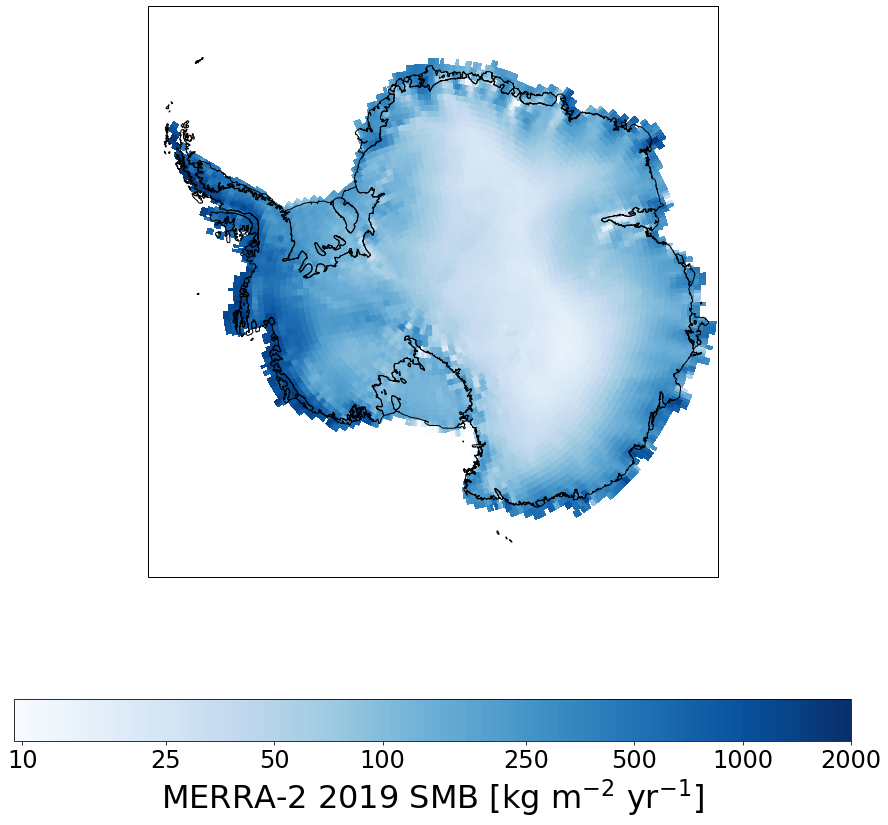

In [89]:
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(15, 15))

# Plot SMB
colormap = Blues_9.mpl_colormap
boundaries = np.logspace(np.log10(10), np.log10(2000), 100)
boundaries = np.insert(boundaries, 0, 0)
norm = colors.BoundaryNorm(boundaries, colormap.N, clip=True)
mesh = plt.pcolormesh(np.linspace(-180, 180, len(evap['lon'])), evap['lat'], smb2019, cmap = colormap, 
                    norm = norm, transform=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, orientation = 'horizontal', ticks = [10, 25, 50, 100, 250, 500, 1000, 2000])
cbar.set_label("MERRA-2 2019 SMB [kg m$^{-2}$ yr$^{-1}$]", size = 32)
cbar.ax.tick_params(labelsize=24)

# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

plt.savefig('2019_AIS_MERRA2_SMB.pdf', format='pdf', dpi=100)

# Figure 3: Map of 2019 SMB annomaly relative to 1981-2010 average

## Load Data

In [90]:
data_path = "/projects/erke2265/SOTC_AIS_SMB/nc_files/"

# Grid Area
ga = xr.open_dataset("/projects/erke2265/SOTC_AIS_SMB/MERRA2_gridarea.nc")
ga = ga['cell_area'][0:101,:]

## Data Manipulation

In [91]:
# Calculate seconds in each month
seconds = np.zeros(480); seconds[:] = np.nan
count = -1
for year in range(1980, 2019 + 1):
    for month in range(1, 12 + 1):
        count = count + 1
        tmp = monthrange(year, month)
        seconds[count] = float(tmp[1]) * 24 * 60 * 60
        
# Grounded Ice Sheet Masks
# Use this mask for grounded ice sheet calculations
# mask_path = "/projects/erke2265/SOTC_AIS_SMB/AIS_Grounded_basins_Zwally_MERRA2grid.nc" 
# Use this mask for to include ice shelves
mask_path = "/projects/erke2265/SOTC_AIS_SMB/AIS_basins_Zwally_MERRA2grid.nc"
mask = xr.open_dataset(mask_path)
mask = mask['Zwallybasins'][0:101,:]
mask = mask / mask

# SMB
smb_yearly = np.zeros([40, 101, 576])
smb_monthly = np.zeros(480)
month_count = -1
year_count = -1
for j in range(1980, 2019 + 1):
    year_count = year_count + 1
    # Precipitation
    sn = xr.open_dataset(data_path + "PRECSN_monthly_" + str(j) + ".nc")
    ls = xr.open_dataset(data_path + "PRECLS_monthly_" + str(j) + ".nc")
    cu = xr.open_dataset(data_path + "PRECCU_monthly_" + str(j) + ".nc")

    # Evaporation 
    evap = xr.open_dataset(data_path + "EVAP_monthly_" + str(j) + ".nc")

    smb = sn['PRECSN'] + ls['PRECLS'] + cu['PRECCU'] - evap['EVAP']
    for k in range(0, 12):
        month_count = month_count + 1
        smb[k,:,:] = smb[k,:,:] * seconds[month_count]
        tmp = smb[k,:,:].values * ga.values * mask.values
        smb_monthly[month_count] = np.nansum(tmp)
    smb = smb.sum(dim = "time").values * mask.values
    smb_yearly[year_count,:,:] = smb

# Reference period of 1981-2010, which corresponds to year indices [1:31]
smb_year_mean = np.nanmean(smb_yearly[1:31,:,:], axis=0)
smb_year_std = np.nanstd(smb_yearly[1:31,:,:], axis=0)

/projects/erke2265/miniconda/envs/a3d/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/projects/erke2265/miniconda/envs/a3d/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


## Plot Map

/projects/erke2265/miniconda/envs/a3d/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


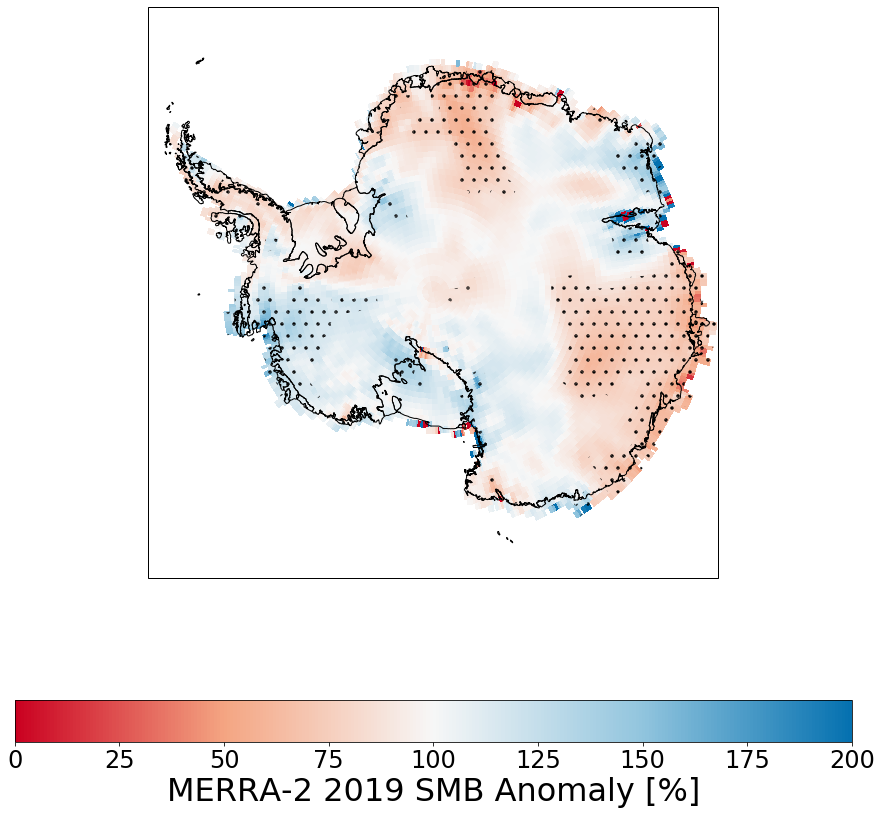

In [92]:
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(15, 15))

# Calculate anomaly and significancd
annomaly = smb2019 / smb_year_mean
significant = (smb2019 - smb_year_mean) / smb_year_std
indices = np.abs(significant) > 1
significant = np.zeros(significant.shape); significant[:] = np.nan
significant[indices] = 1

# Plot SMB
colormap = Blues_9.mpl_colormap
mesh = plt.pcolormesh(np.linspace(-180, 180, len(evap['lon'])), evap['lat'], annomaly * 100, cmap = RdBu_5.mpl_colormap, 
                    transform=ccrs.PlateCarree(), vmin=0, vmax=200)
plt.pcolor(evap['lon'], evap['lat'], significant, hatch='.' , 
                    transform=ccrs.PlateCarree(), alpha=0.)
cbar = plt.colorbar(mesh, orientation = 'horizontal')
cbar.set_label("MERRA-2 2019 SMB Anomaly [%]", size = 32)
cbar.ax.tick_params(labelsize=24)

# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')
plt.savefig('2019_AIS_MERRA2_SMB_Anomaly.pdf', format='pdf', dpi=100)

# Figure 4: Monthly timeseries of 2019 Antarctic SMB

<Figure size 432x288 with 0 Axes>

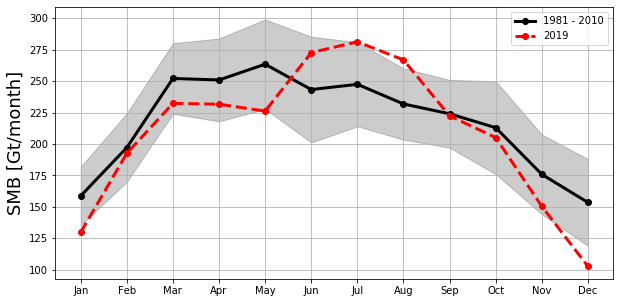

In [85]:
smb2019_monthlyGT = smb2019_monthly / 1e12

# Compute jan,feb,may,...,dec avg smb
# tmp = np.zeros([40,12])
tmp = np.zeros([30,12])
# for j in range(0,40):
for j in range(0, 30):
    minima = j*12
    maxima = j*12 + 12
    tmp[j,:] = smb_monthly[minima:maxima]

avg_smb_monthlyGT = tmp.mean(axis=0) / 1e12
std_smb_monthlyGT = tmp.std(axis=0) / 1e12

    
## Plot Timeseries
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov', 'Dec']
plt.figure(4)
fig4 = plt.figure(figsize = (10, 5))
plt.plot(month, avg_smb_monthlyGT, 'ko-', linewidth=3, label='1981 - 2010')
plt.fill_between(month, avg_smb_monthlyGT - std_smb_monthlyGT, avg_smb_monthlyGT + std_smb_monthlyGT, \
                  facecolor = "black", color = "black", alpha = 0.2)
plt.plot(month, smb2019_monthlyGT.values, 'ro--', linewidth=3, label='2019')
plt.grid()
plt.legend()
# plt.title("MERRA-2 Monthly AIS SMB", fontsize=18)
plt.ylabel("SMB [Gt/month]", fontsize=18)
plt.savefig('2019_AIS_MERRA2_Monthly_SMB.pdf', format='pdf', dpi=100)